# Performance experiments: normal traffic scenarios

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

In [2]:
df = pd.read_csv(
    "traversal_times.csv",
    index_col=0,
    converters={  # to convert the lists from strings to python lists
        "scenario 1": pd.eval,
        "scenario 2": pd.eval,
        "scenario 3": pd.eval,
        "scenario 4": pd.eval,
        "scenario 5": pd.eval,
        "scenario 6": pd.eval,
    },
)
df.map(np.round, decimals=1)

,scenario 1,scenario 2,scenario 3,scenario 4,scenario 5,scenario 6
baseline,"[22.8, 23.1, 22.8]","[29.9, 29.8, 29.8]","[26.1, 26.5, 26.2]","[19.5, 19.6, 19.6]","[22.0, 22.5, 22.2]","[23.3, 22.2, 22.2]"
foresee,"[20.1, 20.6, 14.4]","[26.3, 27.1, 26.8]","[24.4, 24.5, 24.1]","[15.8, 17.1, 17.5]","[21.3, 21.2, 21.9]","[19.1, 18.8, 18.3]"
baseline_pp,"[26.8, 26.5, 26.4]","[34.3, 34.6, 35.0]","[30.1, 32.2, 29.7]","[24.1, 23.4, 24.3]","[27.0, 27.3, 27.0]","[27.0, 25.8, 25.6]"
foresee_pp,"[26.7, 26.8, 28.8]","[30.4, 29.7, 29.2]","[25.8, 25.8, 26.2]","[24.0, 24.2, 23.8]","[27.5, 27.0, 27.8]","[21.6, 20.7, 21.0]"


### 1. Plot the data

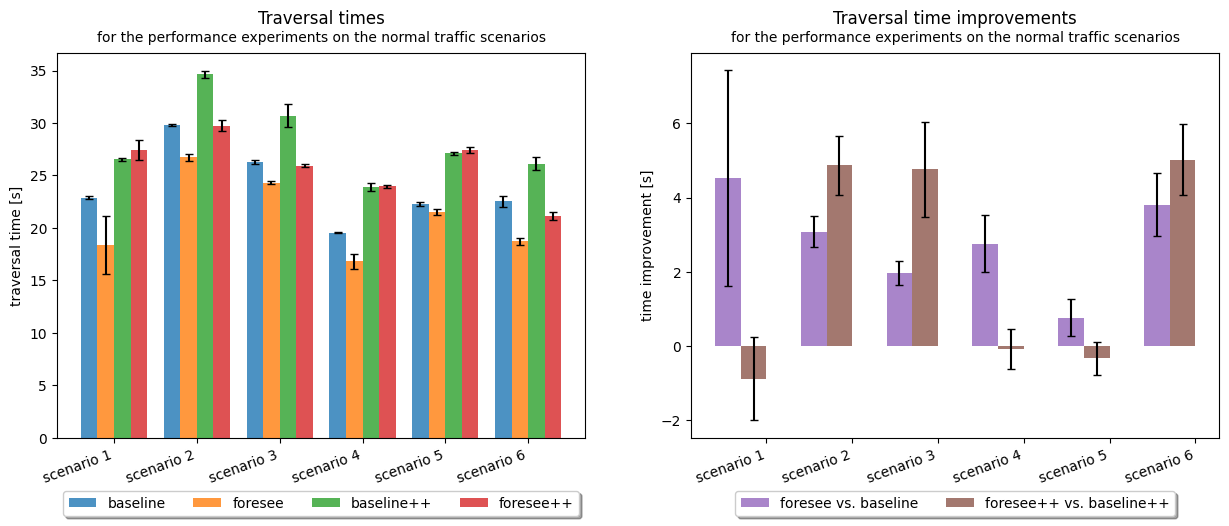

In [3]:
BAR_ALPHA = 0.8
ERROR_BAR_COLOR = "k"
width = 0.2

algorithms = np.array([i.replace("_pp", "++") for i in df.index])
labels = df.columns.to_list()
no_scenarios, no_algorithms = len(labels), len(algorithms)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

xs = np.tile(np.arange(no_algorithms) * width, (no_scenarios, 1)).T + np.arange(no_scenarios)
means = df.map(np.mean).to_numpy()
stds = df.map(np.std).to_numpy()

ax = axs[0]
color_iter = iter(mcolors.TABLEAU_COLORS)
for x, mean, std, algorithm in zip(xs, means, stds, algorithms):
    color = next(color_iter)
    ax.bar(x, mean, width=width, color=color, label=algorithm, alpha=BAR_ALPHA)
    ax.errorbar(x, mean, yerr=std, color=ERROR_BAR_COLOR, ls="none", barsabove=True, capsize=3)

# ax.set_title("Traversal time for all the algorithm types with\nstandard deviation over 3 runs.")
ax.set_title("Traversal times\n")
ax.text(
    0.5,
    1.03,
    "for the performance experiments on the normal traffic scenarios",
    fontsize=10,
    ha="center",
    transform=ax.transAxes,
)
ax.set_ylabel("traversal time [s]")
ax.legend()
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), fancybox=True, shadow=True, ncol=5)
ax.set_xticks(xs.mean(axis=0), labels, rotation=20, ha="right")

ax = axs[1]
width = 0.3
xs = np.tile(np.arange(no_algorithms) * width, (no_scenarios, 1)).T + np.arange(no_scenarios)
baseline_vs_foresee_mean = (
    means[np.where(algorithms == "baseline")[0].squeeze()] - means[np.where(algorithms == "foresee")[0].squeeze()]
)
baseline_vs_foresee_std = (
    stds[np.where(algorithms == "baseline")[0].squeeze()] + stds[np.where(algorithms == "foresee")[0].squeeze()]
)
baseline_vs_foresee_pp_mean = (
    means[np.where(algorithms == "baseline++")[0].squeeze()] - means[np.where(algorithms == "foresee++")[0].squeeze()]
)
baseline_vs_foresee_pp_std = (
    stds[np.where(algorithms == "baseline++")[0].squeeze()] + stds[np.where(algorithms == "foresee++")[0].squeeze()]
)
ax.bar(
    xs[0], baseline_vs_foresee_mean, width=width, color=next(color_iter), alpha=BAR_ALPHA, label="foresee vs. baseline"
)
ax.errorbar(
    xs[0],
    baseline_vs_foresee_mean,
    yerr=baseline_vs_foresee_std,
    color=ERROR_BAR_COLOR,
    ls="none",
    barsabove=True,
    capsize=3,
)
ax.bar(
    xs[1],
    baseline_vs_foresee_pp_mean,
    width=width,
    color=next(color_iter),
    alpha=BAR_ALPHA,
    label="foresee++ vs. baseline++",
)
ax.errorbar(
    xs[1],
    baseline_vs_foresee_pp_mean,
    yerr=baseline_vs_foresee_pp_std,
    color=ERROR_BAR_COLOR,
    ls="none",
    barsabove=True,
    capsize=3,
)

ax.set_title("Traversal time improvements\n")
ax.text(
    0.5,
    1.03,
    "for the performance experiments on the normal traffic scenarios",
    fontsize=10,
    ha="center",
    transform=ax.transAxes,
)
ax.set_ylabel("time improvement [s]")
ax.legend()
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), fancybox=True, shadow=True, ncol=5)
ax.set_xticks(xs.mean(axis=0), labels, rotation=20, ha="right")

plt.savefig("perf_normal_traversal_times.pdf", bbox_inches="tight")

plt.show()

### 2. T-test

Test the significance of the time improvements:

Results:

| Comparison                | 1 | 2 | 3 | 4 | 5 | 6 |
|---------------------------|---|---|---|---|---|---|
| baseline vs. foresee      | X | X | X | X | X | X |
| baseline++ vs. foresee++  |   | X | X |   |   | X |

In [4]:
import statsmodels.api as sm
from math import nan
from copy import deepcopy

In [5]:
for algorithm1, algorithm2 in zip(["baseline", "baseline_pp"], ["foresee", "foresee_pp"]):
    print(f"{algorithm1} vs. {algorithm2}:")
    for scenario in df.columns:
        t_value, p_value, dof = sm.stats.ttest_ind(
            x1=df.loc[algorithm1, scenario],
            x2=df.loc[algorithm2, scenario],
            usevar="unequal",
        )  # returns (t value, p value, degrees of freedom)
        reject = p_value < 0.05 if p_value != nan else None
        print(f"\t{scenario}:\t {t_value=:.3f}\t{p_value=:.3f}\t{dof=:.3f} \t{reject=}")

baseline vs. foresee:
	scenario 1:	 t_value=2.295	p_value=0.148	dof=2.009 	reject=False
	scenario 2:	 t_value=11.941	p_value=0.006	dof=2.083 	reject=True
	scenario 3:	 t_value=12.558	p_value=0.000	dof=4.000 	reject=True
	scenario 4:	 t_value=5.181	p_value=0.035	dof=2.003 	reject=True
	scenario 5:	 t_value=3.078	p_value=0.041	dof=3.684 	reject=True
	scenario 6:	 t_value=8.773	p_value=0.002	dof=3.367 	reject=True
baseline_pp vs. foresee_pp:
	scenario 1:	 t_value=-1.267	p_value=0.328	dof=2.101 	reject=False
	scenario 2:	 t_value=11.917	p_value=0.001	dof=3.492 	reject=True
	scenario 3:	 t_value=5.999	p_value=0.024	dof=2.090 	reject=True
	scenario 4:	 t_value=-0.241	p_value=0.828	dof=2.504 	reject=False
	scenario 5:	 t_value=-1.392	p_value=0.272	dof=2.561 	reject=False
	scenario 6:	 t_value=10.191	p_value=0.001	dof=3.392 	reject=True


Some scenarios have one very good performance because a gap was found. The data does not follow a normal distribution it this cases, which violates the assumption of the t-test. The good performance value is therefore replaced with the worst of the other performances to see if the improvement is significant in that case.

In [14]:
"""
    DEEPCOPY DOES NOT WORK: still changes the underlying data
"""

df_no_extremes = deepcopy(df)

### UNCOMMENT THIS LINE, BUT IT CHANGES THE DATA FOR THE LAST TEST

df_no_extremes.loc["foresee", "scenario 1"][2] = np.max(df_no_extremes.loc["foresee", "scenario 1"])

### END

df_no_extremes.map(np.round, decimals=2)

,scenario 1,scenario 2,scenario 3,scenario 4,scenario 5,scenario 6
baseline,"[22.82, 23.06, 22.77]","[29.88, 29.79, 29.76]","[26.12, 26.49, 26.22]","[19.53, 19.57, 19.58]","[22.03, 22.54, 22.21]","[23.27, 22.16, 22.17]"
foresee,"[20.06, 20.6, 20.6]","[26.25, 27.13, 26.79]","[24.37, 24.47, 24.1]","[15.76, 17.15, 17.5]","[21.33, 21.25, 21.89]","[19.07, 18.81, 18.28]"
baseline_pp,"[26.77, 26.46, 26.43]","[34.26, 34.58, 35.04]","[30.15, 32.24, 29.69]","[24.05, 23.36, 24.31]","[27.04, 27.27, 27.0]","[26.95, 25.85, 25.6]"
foresee_pp,"[26.68, 26.82, 28.8]","[30.36, 29.73, 29.19]","[25.82, 25.8, 26.16]","[23.96, 24.16, 23.82]","[27.54, 27.0, 27.76]","[21.6, 20.69, 21.04]"


In [15]:
DATAFRAME = df_no_extremes

for algorithm1, algorithm2 in zip(["baseline", "baseline_pp"], ["foresee", "foresee_pp"]):
    print(f"{algorithm1} vs. {algorithm2}:")
    for scenario in DATAFRAME.columns:
        t_value, p_value, dof = sm.stats.ttest_ind(
            x1=DATAFRAME.loc[algorithm1, scenario],
            x2=DATAFRAME.loc[algorithm2, scenario],
            usevar="unequal",
        )  # returns (t value, p value, degrees of freedom)
        reject = p_value < 0.05 if p_value != nan else None
        print(f"\t{scenario}:\t {t_value=:.3f}\t{p_value=:.3f}\t{dof=:.3f} \t{reject=}")

baseline vs. foresee:
	scenario 1:	 t_value=12.248	p_value=0.001	dof=2.972 	reject=True
	scenario 2:	 t_value=11.941	p_value=0.006	dof=2.083 	reject=True
	scenario 3:	 t_value=12.558	p_value=0.000	dof=4.000 	reject=True
	scenario 4:	 t_value=5.181	p_value=0.035	dof=2.003 	reject=True
	scenario 5:	 t_value=3.078	p_value=0.041	dof=3.684 	reject=True
	scenario 6:	 t_value=8.773	p_value=0.002	dof=3.367 	reject=True
baseline_pp vs. foresee_pp:
	scenario 1:	 t_value=-1.267	p_value=0.328	dof=2.101 	reject=False
	scenario 2:	 t_value=11.917	p_value=0.001	dof=3.492 	reject=True
	scenario 3:	 t_value=5.999	p_value=0.024	dof=2.090 	reject=True
	scenario 4:	 t_value=-0.241	p_value=0.828	dof=2.504 	reject=False
	scenario 5:	 t_value=-1.392	p_value=0.272	dof=2.561 	reject=False
	scenario 6:	 t_value=10.191	p_value=0.001	dof=3.392 	reject=True


### 3. Two ANOVA

Compare between error measures and no error measures (so `++` or not).

Results:

`Baseline++` vs. `Baseline`: F(1) = 537.7, p $<$ 0.05

`Foresee++` vs. `Foresee`: F(1) = 64.22, p $<$ 0.05

In [36]:
from statsmodels.formula.api import ols 

In [37]:
# convert the data to dataframe with colums: [algorithm, scenario, traversal time]
data = []

for index, row in df.iterrows():
    for scenario, times_list in row.items():
        for traversal_time in times_list:
            data.append([index, scenario, traversal_time])

df_only_cols = pd.DataFrame(data)
df_only_cols.columns = ["algorithm", "scenario", "traversal_time"]

df_only_cols

,algorithm,scenario,traversal_time
0,baseline,scenario 1,22.821830
1,baseline,scenario 1,23.064764
2,baseline,scenario 1,22.767238
3,baseline,scenario 2,29.879209
4,baseline,scenario 2,29.791642
...,...,...,...
67,foresee_pp,scenario 5,27.004167
68,foresee_pp,scenario 5,27.756397
69,foresee_pp,scenario 6,21.600182
70,foresee_pp,scenario 6,20.691036


In [44]:
# Performing two-way ANOVA: baseline++ vs. baseline
df_mask = df_only_cols[(df_only_cols["algorithm"] == "baseline") | (df_only_cols["algorithm"] == "baseline_pp")]

model_two_way_no_interaction_conv_traversal_times = ols(formula='traversal_time ~ C(scenario) + C(algorithm)', data=df_mask).fit()
sm.stats.anova_lm(model_two_way_no_interaction_conv_traversal_times, typ=2) 

,sum_sq,df,F,PR(>F)
C(scenario),415.231922,5.0,270.441833,2.139117e-23
C(algorithm),165.102204,1.0,537.657876,2.879189e-20
Residual,8.905224,29.0,NaN,NaN


In [45]:
# Performing two-way ANOVA: foresee++ vs. foresee
df_mask = df_only_cols[(df_only_cols["algorithm"] == "foresee") | (df_only_cols["algorithm"] == "foresee_pp")]

model_two_way_no_interaction_conv_traversal_times = ols(formula='traversal_time ~ C(scenario) + C(algorithm)', data=df_mask).fit()
sm.stats.anova_lm(model_two_way_no_interaction_conv_traversal_times, typ=2) 

,sum_sq,df,F,PR(>F)
C(scenario),293.475315,5.0,17.643377,5.071504e-08
C(algorithm),213.629667,1.0,64.215771,7.744101e-09
Residual,96.475682,29.0,NaN,NaN
